# Домашняя работа

**Буду решать задачу тематической классификации. Даны тексты, посвященные государственным и муниципальным службам. Формально задача заключается в том, чтобы по тексту определить к какому классу он принадлежит.**

In [3]:
import pandas as pd
df = pd.read_csv('texts_with_sources.csv', usecols = ['text', 'source'])
df.head()

,text,source
0,Начальник Главного оперативного управления Ген...,mil
1,Артиллерийские подразделения общевойскового об...,mil
2,Подразделения морской пехоты Каспийской флотил...,mil
3,Команды на всеармейских этапах конкурсов АрМИ-...,mil
4,На большом учебно-методическом командирском сб...,mil


**Определим описательные статистики, а точнее количество текстов и количество классов, количество слов (без лемматизации и с лемматизацией) в коллекции,
среднюю длину текста в словах и символа и 5 самых частых существительных в текстах каждого класса.**

In [0]:
from collections import Counter
import re
import pymorphy2
from nltk.corpus import stopwords
import nltk
import numpy as np
from functools import reduce
import random

In [0]:
df = df.dropna()

In [0]:
def create_freq(collection):
  result = Counter()
  regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")
  for text in collection:
      result.update(" ".join(regex.findall(re.sub('<br>', ' ', text))).lower().strip().split())
  return result

def create_freq_lem(words, pos = 'all'):
  morph = pymorphy2.MorphAnalyzer()
  result = Counter()
  for word, cnt in words.items():
    if pos != 'all':
      parsed = morph.parse(word)
      if pos in parsed[0].tag:
        result.update({parsed[0].normal_form:cnt})
    else:
      result.update({morph.parse(word)[0].normal_form:cnt})
  return result

words = create_freq(df['text'])
words_lem = create_freq_lem(words)

words_classes = [[source, create_freq_lem(create_freq(df[df.source == source].text), 'NOUN')] for source in df.source.drop_duplicates().values]

In [10]:
print('Число текстов:', df.shape[0])
print('Число классов:', len(df.source.drop_duplicates()))
print('Число слов в коллекции до лемматизации:', len(words.keys()))
print('Число слов в коллекции после лемматизации:', len(words_lem.keys()))
print('Средняя длина текста:', sum([len(re.sub('<br>', ' ', text).strip().split()) for text in df['text']])/df.shape[0], 'слов')
print('Средняя длина текста:', sum([reduce(lambda x,y: x+len(y), re.sub('<br>', ' ', text).strip().split(), 0) for text in df['text']])/df.shape[0], 'символa')
print('5 самых частых существительных в текстах каждого паблика:')
[{source[0]:source[1].most_common(5)} for source in words_classes]

Число текстов: 11526
Число классов: 4
Число слов в коллекции до лемматизации: 80944
Число слов в коллекции после лемматизации: 36713
Средняя длина текста: 85.39059517612354 слов
Средняя длина текста: 583.0526635432934 символa
5 самых частых существительных в текстах каждого паблика:


[{'mil': [('минобороны', 1822),
   ('военный', 1371),
   ('год', 1348),
   ('россия', 1316),
   ('оборона', 916)]},
 {'mchsgov': [('мчс', 3578),
   ('мчсроссия', 1879),
   ('россия', 1702),
   ('спасатель', 711),
   ('год', 561)]},
 {'russianpost': [('почта', 3262),
   ('россия', 2631),
   ('год', 2105),
   ('отделение', 1605),
   ('письмо', 1492)]},
 {'mospolice': [('мвд', 5948),
   ('полиция', 5927),
   ('год', 5324),
   ('москва', 4261),
   ('россия', 3995)]}]

### Полученные слова выглядят довольно правдоподобно. Большинство слов действительно характеризуют свой класс, но есть и несколько общих слов (год, Россия и т.д)

### Теперь попробуем классифицировать тексты следующим образом. Если встречается слово $w$, то текст относится к паблику $c$.
### И посмотрим на соответсвующие метрики качества классификации.

### Для классификации по правилам выбираем наиболее часто встречающиеся слова для каждого класса, исключая общие слова

In [0]:
def dummy_predict(text):
  regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")
  morph = pymorphy2.MorphAnalyzer()
  
  words_mil = ['минобороны', 'военный', 'оборона', 'учение', 'сила', 'флот', 'корабль']
  words_mchs = ['мчс', 'мчсроссия', 'спасатель', 'помощь', 'пожар']
  words_post = ['почта', 'отделение', 'письмо', 'открытка', 'марка', 'почтароссия', 'отправление']
  words_police = ['мвд', 'полиция', 'сотрудник', 'петровка', 'увд', 'служба', 'дело']
  
  words = " ".join(regex.findall(text)).lower().strip().split()
  words_lem = set([morph.parse(word)[0].normal_form for word in words])
  
  if any(word in words_mil for word in words_lem):
    return 'mil'
  
  elif any(word in words_mchs for word in words_lem):
    return 'mchsgov'
  
  elif any(word in words_post for word in words_lem):
    return 'russianpost'
  
  elif any(word in words_police for word in words_lem):
    return 'mospolice'
  
  else:
    return random.choice(['mil', 'mchsgov', 'russianpost', 'mospolice'])

In [0]:
y_true = df.source.values
y_pred = [dummy_predict(text) for text in df.text.values]

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
print('Точность:', precision_score(y_true, y_pred, average='macro'))
print('Полнота:', recall_score(y_true, y_pred, average='macro'))
print('f-мера:', f1_score(y_true, y_pred, average='macro'))
print('Доля правильных ответов:', accuracy_score(y_true, y_pred));

Точность: 0.8237741209961454
Полнота: 0.8199070624052849
f-мера: 0.8208588660763408
Доля правильных ответов: 0.8208398403609232


Идеального классификатора не получилось, но качество довольно неплохое

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text.values, df.source.values, test_size=0.3, random_state=42)

### Теперь попробуем использовать sklearn.pipeline для классификации текстов. Используем векторизацию, $tf-idf$ взвешивание и классификатор AdaBoost. Затем посмотрим на метрики качетсва классификации и матрицу ошибок.


 

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier

count_vect = CountVectorizer()
tf_transformer = TfidfTransformer()
AdaBoost = AdaBoostClassifier()

pipeline = Pipeline([('vect', count_vect), ('tfidf', tf_transformer), ('boost', AdaBoost)])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [17]:
print('Точность:', precision_score(y_test, y_pred, average='macro'))
print('Полнота:', recall_score(y_test, y_pred, average='macro'))
print('f-мера:', f1_score(y_test, y_pred, average='macro'))
print('Доля правильных ответов:', accuracy_score(y_test, y_pred));

Точность: 0.8452366610560643
Полнота: 0.8382585761416421
f-мера: 0.8395470833510258
Доля правильных ответов: 0.8383458646616542


### Видно, что качество немного улучшилось по стравнению с наивной моделью

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

  
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


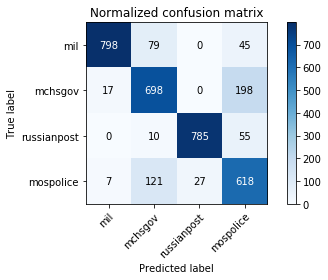

In [21]:
plot_confusion_matrix(y_test, y_pred, classes=['mil', 'mchsgov', 'russianpost', 'mospolice'], normalize=False,
                      title='Normalized confusion matrix');

plt.show()

### Из матрицы видно, что чаще всего классификатор ошибается при разделении постов МЧС и полиции

### Реализуем модель Kim et al (2014) для решения задачи классификации с помощью CNN. И оценим её.
### Ссылка: Kim Y. Convolutional Neural Networks for Sentence Classification. 2014

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

Using TensorFlow backend.


In [0]:
VOCABULARY_SIZE = 250000
EMBEDDING_DIM = 300
MAX_FEATURES = 5000
batch_size = 32

nb_epoch = 10

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.text.values, df.source.values, test_size=0.3, random_state=42)

In [0]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_train)

In [0]:
sequences = tokenizer.texts_to_sequences(X_train)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(X_test)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [0]:
le = LabelEncoder()
le.fit(df.source.drop_duplicates().values)
y_train = np_utils.to_categorical(le.transform(y_train), 4)
y_test = le.transform(y_test)

In [28]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE,
                    EMBEDDING_DIM,
                    input_length=MAX_FEATURES,
                    trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 7261 samples, validate on 807 samples
Epoch 1/10
7261/7261 [==============================] - 35s 5ms/step - loss: 0.3384 - acc: 0.8916 - val_loss: 0.1513 - val_acc: 0.9678
Epoch 2/10
7261/7261 [==============================] - 28s 4ms/step - loss: 0.0738 - acc: 0.9820 - val_loss: 0.1609 - val_acc: 0.9703
Epoch 3/10
7261/7261 [==============================] - 29s 4ms/step - loss: 0.0393 - acc: 0.9901 - val_loss: 0.1858 - val_acc: 0.9678
Epoch 4/10
7261/7261 [==============================] - 29s 4ms/step - loss: 0.0248 - acc: 0.9938 - val_loss: 0.1970 - val_acc: 0.9665
Epoch 5/10
7261/7261 [==============================] - 28s 4ms/step - loss: 0.0206 - acc: 0.9948 - val_loss: 0.2025 - val_acc: 0.9665
Epoch 6/10
7261/7261 [=====================

In [0]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

In [30]:
print('Точность:', precision_score(y_test, y_pred, average='macro'))
print('Полнота:', recall_score(y_test, y_pred, average='macro'))
print('f-мера:', f1_score(y_test, y_pred, average='macro'))
print('Доля правильных ответов:', accuracy_score(y_test, y_pred));

Точность: 0.9596288475212783
Полнота: 0.9593898362492401
f-мера: 0.9593993700034401
Доля правильных ответов: 0.9600925390399074


Confusion matrix, without normalization


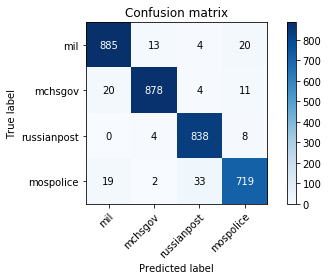

In [31]:
plot_confusion_matrix(y_test, y_pred, classes=['mil', 'mchsgov', 'russianpost', 'mospolice'], normalize=False,
                      title='Confusion matrix');
plt.show()

### Путаем военных с полицией и довольно часто ошибаемся в определении полиции вцелом

### Используем  RNN (BLSTM с какими-то признаками и пулинг поверх) для решения задачи текстовой классификации. Оценим результат.

In [0]:
X_train, X_test, y_train, Y_test = train_test_split(df.text.values, df.source.values, test_size=0.3)

In [0]:
from keras.preprocessing import sequence

TEXT_LENGTH = 400
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(X_test)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [34]:
X_train.shape, X_test.shape

((8068, 500), (3458, 500))

In [0]:
le = LabelEncoder()
le.fit(df.source.drop_duplicates().values)
y_train = np_utils.to_categorical(le.transform(y_train), 4)
y_test = np_utils.to_categorical(le.transform(Y_test), 4)

In [0]:
max_length = max([len(el) for el in X_train])
top_words = 1000

In [37]:
from keras.layers import LSTM

embedding_vecor_length = 128
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          128000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 193,924
Trainable params: 193,924
Non-trainable params: 0
_________________________________________________________________
None
Train on 8068 samples, validate on 3458 samples
Epoch 1/3
8068/8068 [==============================] - 52s 6ms/step - loss: 0.5704 

In [0]:
y_pred = model.predict_classes(X_test)
y_pred = le.inverse_transform(y_pred)

In [39]:
print('Точность:', precision_score(Y_test, y_pred, average='macro'))
print('Полнота:', recall_score(Y_test, y_pred, average='macro'))
print('f-мера:', f1_score(Y_test, y_pred, average='macro'))
print('Доля правильных ответов:', accuracy_score(Y_test, y_pred));

Точность: 0.45038403660169846
Полнота: 0.42860998962736263
f-мера: 0.3594330204170384
Доля правильных ответов: 0.41960670908039327


Confusion matrix, without normalization


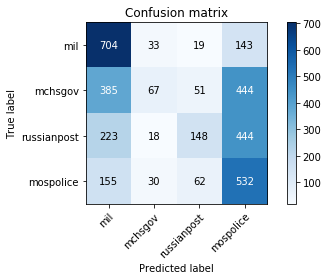

In [40]:
plot_confusion_matrix(Y_test, y_pred, classes=['mil', 'mchsgov', 'russianpost', 'mospolice'], normalize=False,
                      title='Confusion matrix');
plt.show()

### В этом случае результаты совсем неважные.

### Как видно, лучше всего себя показала модель  Kim et al (2014).